In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use('ggplot')

In [2]:
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version:  2.11.0
GPU detected: []


# Step 2: Load and Explore the ner dataset

In [4]:
df = pd.read_csv('ner_dataset.csv', encoding='latin1')
df = df.fillna(method='ffill')
df.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
print('unique word in corpus: ', df['Word'].nunique())
print('unique tags in corpus: ', df['Tag'].nunique())

unique word in corpus:  35178
unique tags in corpus:  17


In [8]:
words=list(set(df['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [9]:
tags = list(set(df['Tag'].values))
num_tags = len(tags)

# Step 3: Retrieve Sentences and corresponding Tags

In [10]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(df)
sentences = getter.sentences

In [15]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

# Step 4: Define Mappings between Sentences and Tags

In [17]:
word2idx = {w:i+1 for i, w in enumerate(words)}
tag2idx = {t:i for i, t in enumerate(tags)}

In [18]:
word2idx

{'hemorrhage': 1,
 'make-believe': 2,
 '1765': 3,
 'Planche': 4,
 'Shalom': 5,
 'Coach': 6,
 'abruptly': 7,
 'Salma': 8,
 'road-block': 9,
 'stave': 10,
 'Baylesa': 11,
 'Al-Arabiya': 12,
 'Qureia': 13,
 'obligations': 14,
 'Chandrika': 15,
 'dazzled': 16,
 'headache': 17,
 'juvenile': 18,
 'Institute': 19,
 'swooped': 20,
 'barricaded': 21,
 'acquitted': 22,
 'liner': 23,
 'harangued': 24,
 'militias': 25,
 'Multan': 26,
 'Zhvania': 27,
 'Hao': 28,
 'Dynastic': 29,
 'Gymnastics': 30,
 'Togo': 31,
 'Closer': 32,
 'children': 33,
 'acorn': 34,
 'Kroes': 35,
 'Guys': 36,
 'success': 37,
 'destabilization': 38,
 'Barzani': 39,
 'Anton': 40,
 'Khushab': 41,
 'Budapest': 42,
 'Qais': 43,
 'stiffly': 44,
 'struggled': 45,
 'Washington': 46,
 'frisked': 47,
 'Mekdad': 48,
 'disapora': 49,
 'tarnished': 50,
 '668': 51,
 'Zhejiang': 52,
 'servant': 53,
 'principalities': 54,
 'Gafir': 55,
 'Mushahid': 56,
 'Ghazi': 57,
 '80-kilometer-long': 58,
 'remedy': 59,
 'Tornadoes': 60,
 'gunned': 61,
 '

In [19]:
tag2idx

{'I-art': 0,
 'I-gpe': 1,
 'B-per': 2,
 'I-org': 3,
 'I-geo': 4,
 'B-art': 5,
 'O': 6,
 'I-tim': 7,
 'B-nat': 8,
 'B-eve': 9,
 'I-nat': 10,
 'B-org': 11,
 'I-eve': 12,
 'B-gpe': 13,
 'B-tim': 14,
 'B-geo': 15,
 'I-per': 16}

# Step 5: Padding input sentence and creating train/test split

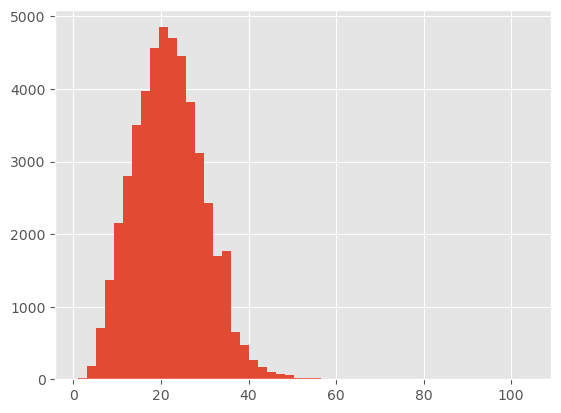

In [20]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)
X

array([[30003,  2561, 34971, ..., 35178, 35178, 35178],
       [22213,  2329,  9060, ..., 35178, 35178, 35178],
       [ 2510, 34838, 30629, ..., 35178, 35178, 35178],
       ...,
       [10941,  6250, 18526, ..., 35178, 35178, 35178],
       [ 1211,  9455, 31565, ..., 35178, 35178, 35178],
       [12879,  8720,  3287, ..., 35178, 35178, 35178]])

In [29]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y

array([[ 6,  6,  6, ...,  6,  6,  6],
       [13,  6,  6, ...,  6,  6,  6],
       [ 6,  6, 14, ...,  6,  6,  6],
       ...,
       [ 6, 15,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6, 11,  3, ...,  6,  6,  6]])

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Step 6: Build and compile bidirectional LSTM model

In [31]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional

In [33]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [34]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

# Step 7: Train the model

In [36]:
!pip install livelossplot

Defaulting to user installation because normal site-packages is not writeable


In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

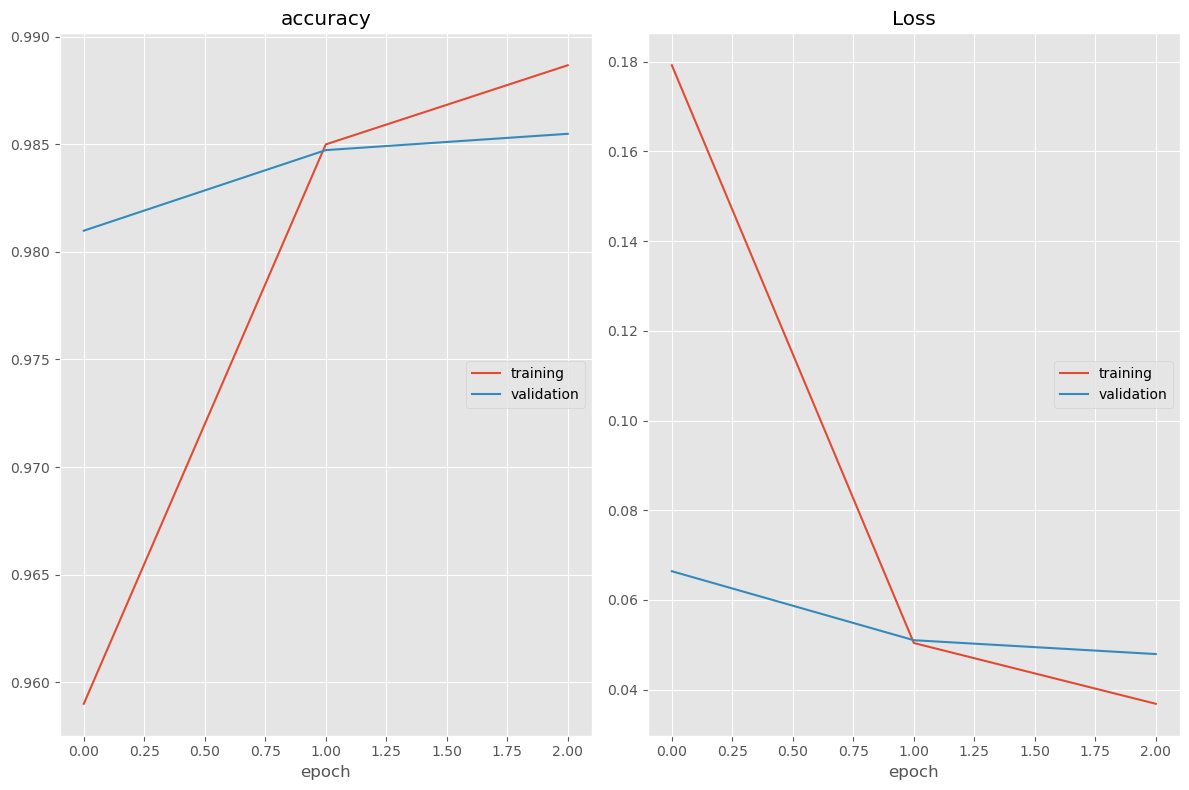

accuracy
	training         	 (min:    0.959, max:    0.989, cur:    0.989)
	validation       	 (min:    0.981, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.037, max:    0.179, cur:    0.037)
	validation       	 (min:    0.048, max:    0.066, cur:    0.048)

Epoch 3: val_loss improved from 0.05101 to 0.04792, saving model to model_weights.h5
1199/1199 [==============================] - 182s 152ms/step - loss: 0.0368 - accuracy: 0.9887 - val_loss: 0.0479 - val_accuracy: 0.9855
Wall time: 9min 21s


In [38]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)


# Step 8: Evaluate the Model

In [39]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 9s 29ms/step - loss: 0.0479 - accuracy: 0.9855


[0.047922421246767044, 0.9854816794395447]

In [44]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 54ms/step
Word           True 	 Pred

------------------------------
A              O	O
U.S.           B-geo	B-geo
soldier        O	O
was            O	O
one            O	O
of             O	O
at             O	O
least          O	O
four           O	O
people         O	O
wounded        O	O
.              O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552            O	O
552    